In [1]:
import pandas as pd
import numpy as np
import spacy
import en_core_web_sm

In [2]:
df=pd.read_csv("NonSpam1.csv") 

In [3]:
df.head()

,Unnamed: 0,label,text,label_num
0,0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4,ham,Subject: re : indian springs\r\nthis deal is t...,0
4,5,ham,Subject: ehronline web address change\r\nthis ...,0


In [4]:
df.shape

(3672, 4)

In [5]:
df.isnull().sum(axis = 0)

Unnamed: 0    0
label         0
text          0
label_num     0
dtype: int64

In [6]:
# Run in terminal or command prompt
# python3 -m spacy download en
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim
# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
# Plotting tools
#import pyLDAvis
#import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

/Users/muditagarg/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [7]:
pip install pyLDAvis

Note: you may need to restart the kernel to use updated packages.


In [8]:
data=df.text.values.tolist()

In [9]:
data = [re.sub(r'\s+', ' ', sent) for sent in data]

In [10]:
data = [re.sub(r"\'", "", sent) for sent in data]

In [11]:
pprint(data[:1])

['Subject: enron methanol ; meter # : 988291 this is a follow up to the note i '
 'gave you on monday , 4 / 3 / 00 { preliminary flow data provided by daren } '
 '. please override pop  s daily volume { presently zero } to reflect daily '
 'activity you can obtain from gas control . this change is needed asap for '
 'economics purposes .']


In [12]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data_words = list(sent_to_words(data))
print(data_words[:1])

[['subject', 'enron', 'methanol', 'meter', 'this', 'is', 'follow', 'up', 'to', 'the', 'note', 'gave', 'you', 'on', 'monday', 'preliminary', 'flow', 'data', 'provided', 'by', 'daren', 'please', 'override', 'pop', 'daily', 'volume', 'presently', 'zero', 'to', 'reflect', 'daily', 'activity', 'you', 'can', 'obtain', 'from', 'gas', 'control', 'this', 'change', 'is', 'needed', 'asap', 'for', 'economics', 'purposes']]


In [13]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']): #'NOUN', 'ADJ', 'VERB', 'ADV'
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

In [14]:
sp = spacy.load("en_core_web_sm")

In [15]:
# Initialize spacy ‘en’ model, keeping only tagger component (for efficiency)
# Run in terminal: python -m spacy download en
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'VERB']) #select noun and verb
print(data_lemmatized[:2])

['methanol meter follow note give flow datum provide override volume reflect activity can obtain gas control change need asap economic purpose', 'see attach file']


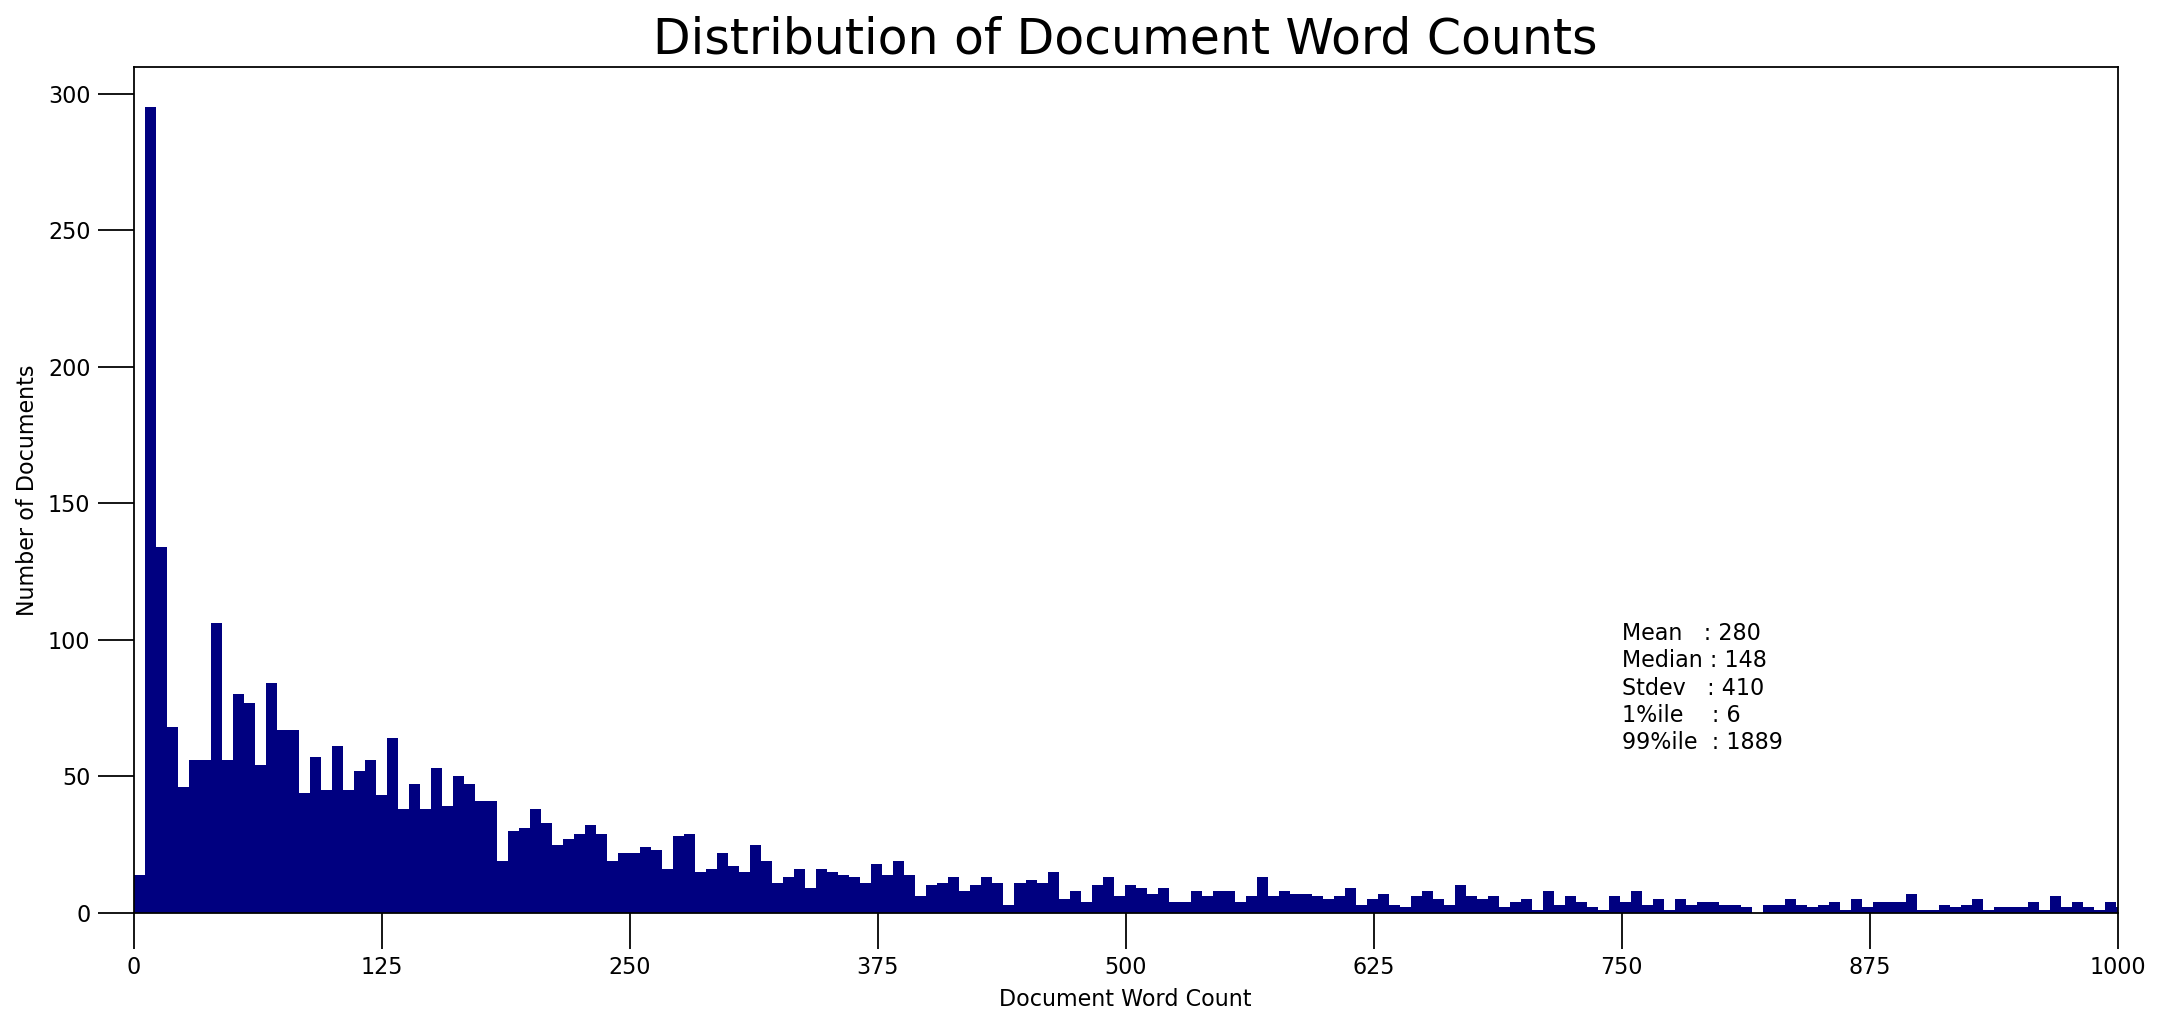

In [16]:
#Frequency Distribution of Word Counts in Documents

doc_lens = [len(d) for d in data_lemmatized]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

In [17]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,
# minimum reqd occurences of a word 
                             stop_words='english',             
# remove stop words
                             lowercase=True,                   
# convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  
# num chars > 3
                             # max_features=50000,             
# max number of uniq words    
                            )
data_vectorized = vectorizer.fit_transform(data_lemmatized)

In [18]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=20,               # Number of topics
                                      max_iter=10,               
# Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          
# Random state
                                      batch_size=128,            
# n docs in each learning iter
                                      evaluate_every = -1,       
# compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               
# Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)
print(lda_model)  # Model attributes

LatentDirichletAllocation(learning_method='online', n_components=20, n_jobs=-1,
                          random_state=100)


In [19]:
LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
 evaluate_every=-1, learning_decay=0.7,
 learning_method='online', learning_offset=10.0,
 max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
 n_components=10, n_jobs=-1, perp_tol=0.1,
 random_state=100, topic_word_prior=None,
 total_samples=1000000.0, verbose=0)

LatentDirichletAllocation(learning_method='online', n_jobs=-1, random_state=100)

In [41]:
pip install pyldavis

Note: you may need to restart the kernel to use updated packages.


In [20]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))
# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))
# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -718685.926504486
Perplexity:  355.111797436037
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 20,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [21]:
pip install pandas --upgrade

Note: you may need to restart the kernel to use updated packages.


In [22]:
# Create Document — Topic Matrix
lda_output = lda_model.transform(data_vectorized)
# column names
topicnames = ["Topic" + str(i) for i in range(lda_model.n_components)]
# index names
docnames = ["Doc" + str(i) for i in range(len(data))]
# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)
# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic
# Styling
def color_green(val):
 color = 'green' if val > .1 else 'black'
 return 'color: {col}'.format(col=color)
def make_bold(val):
 weight = 700 if val > .1 else 400
 return 'font-weight: {weight}'.format(weight=weight)
# Apply Style


In [23]:
df_document_topics = df_document_topic.head(15)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,...,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,dominant_topic
Doc0,0.00,0.00,0.00,0.32,0.00,0.38,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.26,0.00,5
Doc1,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,...,0.02,0.02,0.68,0.02,0.02,0.02,0.02,0.02,0.02,13
Doc2,0.00,0.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,...,0.00,0.86,0.00,0.00,0.00,0.04,0.00,0.00,0.00,12
Doc3,0.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.10,0.06,0.00,0.00,10
Doc4,0.00,0.31,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.59,0.00,0.07,0.00,0.00,0.00,0.00,13
Doc5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.03,0.00,0.00,0.00,0.00,0.96,0.00,0.00,0.00,16
Doc6,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,10
Doc7,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,0.51,0.26,0.01,0.01,0.01,0.01,0.01,13
Doc8,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,...,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.52,19
Doc9,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.51,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,11


In [24]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda_model.components_)
# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames
# View
df_topic_keywords.head()

/Users/muditagarg/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,ability,absence,accept,acceptance,access,accomplish,accord,account,accountant,accounting,...,work,worksheet,world,write,writeoff,www,year,yesterday,zero,zone
Topic0,0.052152,0.050006,0.051010,0.050006,0.050035,0.050006,0.050006,0.050104,2.822028,0.055691,...,5.776988,0.050006,0.050007,51.309820,29.933992,0.050099,0.061841,0.050006,0.050005,0.050007
Topic1,0.050018,0.050010,0.050236,0.050007,39.703193,0.050005,0.050023,0.052291,0.050007,0.050008,...,11.151897,0.050014,19.927074,0.050013,0.050006,116.821885,0.050006,0.050005,0.050006,0.050007
Topic2,0.050015,0.050005,0.050007,0.050005,0.050008,0.050011,0.050015,0.050005,0.050014,0.050006,...,0.050683,0.050005,0.050005,0.050005,0.050006,0.050006,0.050012,0.050005,0.050006,0.050007
Topic3,0.050012,0.050007,0.050356,0.050005,0.050008,0.050015,8.651325,0.050157,0.050010,89.469962,...,35.437868,0.050009,0.050005,0.051337,0.050159,0.050005,0.053527,24.341350,45.164840,0.050823
Topic4,0.050005,20.765511,0.050007,0.050006,0.050007,0.050007,0.050007,9.571032,0.050005,0.050010,...,0.050363,0.050005,16.195780,34.337269,0.050006,2.473616,0.062417,16.388610,0.050006,0.050009


In [25]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords
topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=15)
# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

/Users/muditagarg/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,gas,day,volume,nomination,supply,nominate,month,thank,forward,production,flow,shut,follow,need,record
Topic 1,com,message,send,mail,email,http,address,service,www,internet,web,visit,hotmail,receive,letter
Topic 2,location,list,stock,corporation,monitor,locate,reflect,station,quote,floor,department,communicate,create,aim,website
Topic 3,meter,deal,volume,thank,need,flow,day,know,gas,let,contract,month,allocate,issue,forward
Topic 4,phone,say,person,know,thank,people,number,hope,fax,love,tell,tax,form,copy,ask
Topic 5,plant,point,outage,methanol,control,schedule,phone,payment,class,pay,sit,charge,requirement,follow,farmer
Topic 6,ect,deal,production,meter,gas,sitara,spot,grave,ticket,oil,follow,create,forward,purchase,thank
Topic 7,company,cost,rate,survey,service,provide,activity,employee,option,month,year,work,agreement,process,state
Topic 8,desk,transport,service,power,group,need,path,work,manager,pipe,expense,sell,unify,stacey,analyst
Topic 9,txu,experience,lesson,neon,parent,child,sort,bar,spread,respond,fun,offset,improve,morning,say


In [53]:
df_topic_keywords.head()

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Topics
Topic 0,gas,day,volume,nomination,supply,nominate,month,thank,forward,production,flow,shut,follow,need,record,Transporatation
Topic 1,com,message,send,mail,email,http,address,service,www,internet,web,visit,hotmail,receive,letter,Exigency
Topic 2,location,list,stock,corporation,monitor,locate,reflect,station,quote,floor,department,communicate,create,aim,website,Contact/Support
Topic 3,meter,deal,volume,thank,need,flow,day,know,gas,let,contract,month,allocate,issue,forward,Requisition
Topic 4,phone,say,person,know,thank,people,number,hope,fax,love,tell,tax,form,copy,ask,Notification


In [26]:
Topics = ["Transporatation","Exigency","Contact/Support","Requisition","Notification", 
          "Healthcare", "Basic Details", "Order processing", "Graphic Design", 
          "Delivery details","Personal details","Allocation","Frontend","Software",
          "Stock information","Operation","Transaction","Process","Time period","Travelling"]
df_topic_keywords["Topics"]=Topics
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Topics
Topic 0,gas,day,volume,nomination,supply,nominate,month,thank,forward,production,flow,shut,follow,need,record,Transporatation
Topic 1,com,message,send,mail,email,http,address,service,www,internet,web,visit,hotmail,receive,letter,Exigency
Topic 2,location,list,stock,corporation,monitor,locate,reflect,station,quote,floor,department,communicate,create,aim,website,Contact/Support
Topic 3,meter,deal,volume,thank,need,flow,day,know,gas,let,contract,month,allocate,issue,forward,Requisition
Topic 4,phone,say,person,know,thank,people,number,hope,fax,love,tell,tax,form,copy,ask,Notification
Topic 5,plant,point,outage,methanol,control,schedule,phone,payment,class,pay,sit,charge,requirement,follow,farmer,Healthcare
Topic 6,ect,deal,production,meter,gas,sitara,spot,grave,ticket,oil,follow,create,forward,purchase,thank,Basic Details
Topic 7,company,cost,rate,survey,service,provide,activity,employee,option,month,year,work,agreement,process,state,Order processing
Topic 8,desk,transport,service,power,group,need,path,work,manager,pipe,expense,sell,unify,stacey,analyst,Graphic Design
Topic 9,txu,experience,lesson,neon,parent,child,sort,bar,spread,respond,fun,offset,improve,morning,say,Delivery details


In [27]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [28]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/muditagarg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
stop = set(stopwords.words('english'))
stop.update(['Word','Topic','forward'])

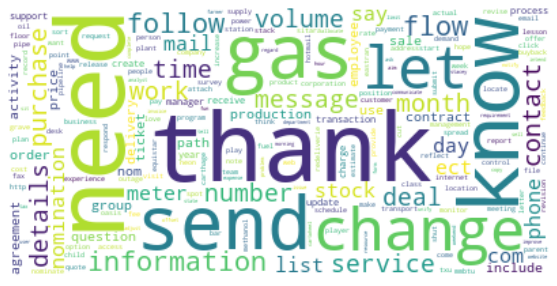

In [30]:
wordcloud = WordCloud( stopwords = stop, max_font_size=70, background_color="white").generate(str(df_topic_keywords))
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [55]:
# Define function to predict topic for a given text document.
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
def predict_topic(text, nlp=nlp):
    global sent_to_words
    global lemmatization
# Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))
# Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
# Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)
# Step 4: LDA Transform
    topic_probability_scores = lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), 1:14].values.tolist()
    
    # Step 5: Infer Topic
    infer_topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), -1]
    
    #topic_guess = df_topic_keywords.iloc[np.argmax(topic_probability_scores), Topics]
    return infer_topic, topic, topic_probability_scores
# Predict the topic
mytext = ["tomorrow, i would like to refine this spreadsheet and try to support some of the population and job growth assumptions with more current data.let me know what you think."]
infer_topic, topic, prob_scores = predict_topic(text = mytext)
print(topic)
print(infer_topic)


['want', 'time', 'week', 'let', 'think', 'come', 'need', 'make', 'start', 'work', 'problem', 'hour', 'weekend']
Frontend


In [32]:
def apply_predict_topic(text):
 text = [text]
 infer_topic, topic, prob_scores = predict_topic(text = text)
 return(infer_topic)
df["Topic_key_word"]= df['text'].apply(apply_predict_topic)
df.head()

,Unnamed: 0,label,text,label_num,Topic_key_word
0,0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0,Healthcare
1,1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,Software
2,2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,Frontend
3,4,ham,Subject: re : indian springs\r\nthis deal is t...,0,Personal details
4,5,ham,Subject: ehronline web address change\r\nthis ...,0,Software


In [33]:
df.drop(['Unnamed: 0', 'label_num'], axis = 1)

,label,text,Topic_key_word
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,Healthcare
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",Software
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",Frontend
3,ham,Subject: re : indian springs\r\nthis deal is t...,Personal details
4,ham,Subject: ehronline web address change\r\nthis ...,Software
...,...,...,...
3667,ham,"Subject: fw : crosstex energy , driscoll ranch...",Basic Details
3668,ham,Subject: put the 10 on the ft\r\nthe transport...,Software
3669,ham,Subject: 3 / 4 / 2000 and following noms\r\nhp...,Stock information
3670,ham,Subject: calpine daily gas nomination\r\n>\r\n...,Transporatation


In [34]:
df.groupby("Topic_key_word").nunique()

,Unnamed: 0,label,text,label_num
Topic_key_word,,,,
Allocation,94,1,93,1
Basic Details,231,1,221,1
Contact/Support,4,1,4,1
Delivery details,11,1,11,1
Exigency,125,1,123,1
Frontend,179,1,175,1
Graphic Design,91,1,87,1
Healthcare,50,1,41,1
Notification,107,1,104,1


In [35]:
# df.to_csv("FinalTopic_Result.csv")

In [36]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)
# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)
# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]
# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))
# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.12  0.04  0.02  0.89  0.05  0.05  0.14  0.05  0.07  0.02  0.28  0.06
   0.1   0.2   0.08  0.06  0.02  0.05  0.09  0.08]
 [ 0.07  0.07  0.03 -0.34  0.05  0.04  0.07  0.07  0.05  0.03  0.16  0.07
   0.09  0.88  0.11  0.06  0.04  0.08  0.13  0.07]]
Perc of Variance Explained: 
 [0.12 0.15]


In [ ]:
df.head(10)

Text(0.5, 1.0, 'Segregation of Topic Clusters')

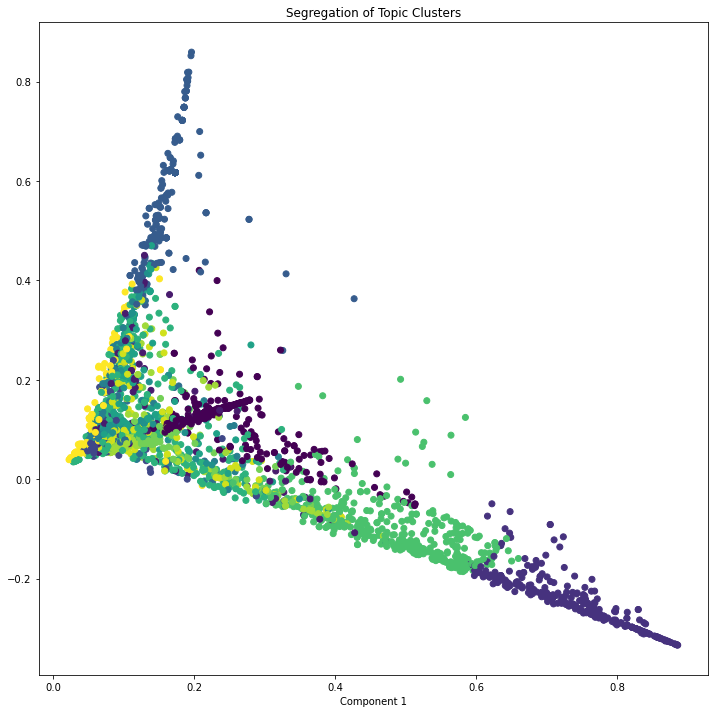

In [37]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

In [63]:
import joblib

joblib.dump(lda_model, 'lda_model.jl')
# then reload it with
lda_model = joblib.load('lda_model.jl')


## Data Visualisation

In [67]:
!pip3 install pyLDAvis

In [68]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [72]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')
panel

/Users/muditagarg/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/muditagarg/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/Users/muditagarg/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/muditagarg/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/muditagarg/opt/ana

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
3      -10.878068   10.538728       1        1  16.037707
10     -60.884026  -75.591820       2        1   9.311745
6       -2.336119  -53.289074       3        1   9.015239
17     -61.385319  -12.914634       4        1   6.894681
12     -28.737743  126.296997       5        1   6.182310
7        1.066606 -123.552811       6        1   5.384231
13      45.140720   -7.947869       7        1   5.192258
8     -140.795975  -98.530548       8        1   5.068565
0       61.531681  -83.240562       9        1   4.793779
11     -72.563057 -140.396881      10        1   4.793038
18      15.984491   63.578186      11        1   4.712798
15    -160.851624   68.945145      12        1   4.248951
1       85.961830   51.922935      13        1   3.971659
4      -99.020836  109.936348      14        1   3.430272
16    -176.764130   -8.681684      15        1   2.675734
5     -117.189880  -37.420200      16        1   2.590246
14     108.829918  -22.946203      17        1   2.483028
19      47.588097  121.934814      18        1   1.818464
2     -106.467834   30.176889      19        1   0.970563
9      -50.613804   59.328842      20        1   0.424732, topic_info=          Term         Freq        Total Category  logprob  loglift
459        gas  2330.000000  2330.000000  Default  30.0000  30.0000
274       deal  3368.000000  3368.000000  Default  29.0000  29.0000
652      meter  2350.000000  2350.000000  Default  28.0000  28.0000
1094    ticket   827.000000   827.000000  Default  27.0000  27.0000
74      attach  1008.000000  1008.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
362      enter     0.062603   319.040535  Topic20  -9.0244  -3.0748
274       deal     0.062599  3368.623374  Topic20  -9.0245  -5.4318
268   database     0.062591    46.098169  Topic20  -9.0246  -1.1404
804      price     0.062589   852.512432  Topic20  -9.0246  -4.0579
582        let     0.062574  1083.392618  Topic20  -9.0249  -4.2978

[1073 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1        14  0.969602     absence
3        12  0.932645  acceptance
4         7  0.778487      access
4        13  0.214755      access
6         1  0.110508      accord
...     ...       ...         ...
1195      4  0.339067        year
1195      5  0.257691        year
1195      6  0.328895        year
1195     11  0.050860        year
1198      3  0.982517        zone

[2403 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 11, 7, 18, 13, 8, 14, 9, 1, 12, 19, 16, 2, 5, 17, 6, 15, 20, 3, 10])